In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import json
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler as lrs
import time
import os
import copy
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


def process(data_loader):
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        custom_imshow(inputs[0])


def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


def dataset_check(class_name_dict, image_show_count, data_loaders):
    # train check
    inputs, classes = next(iter(data_loaders['train']))
    out = torchvision.utils.make_grid(inputs[:image_show_count])  # batch의 이미지를 오려부친다
    imshow(out, title=[class_name_dict[str(int(x))] for x in classes[:image_show_count]])
    # valid check
    inputs, classes = next(iter(data_loaders['val']))
    out = torchvision.utils.make_grid(inputs[:image_show_count])  # batch의 이미지를 오려부친다
    imshow(out, title=[class_name_dict[str(int(x))] for x in classes[:image_show_count]])
    # test check
    inputs, classes = next(iter(data_loaders['test']))
    out = torchvision.utils.make_grid(inputs[:image_show_count])  # batch의 이미지를 오려부친다
    imshow(out, title=[class_name_dict[str(int(x))] for x in classes[:image_show_count]])


def load_datasets_with_test(data_resize=224, train_dataset_dir='./test_datasets/train',
                           test_dataset_dir='./test_datasets/test', val_dataset_dir='./test_datasets/val',
                           batch_size=12, shuffle=True, num_workers=8):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((data_resize, data_resize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((data_resize, data_resize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((data_resize, data_resize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    train_dataset = datasets.ImageFolder(root=train_dataset_dir, transform=data_transforms['train'])
    test_dataset = datasets.ImageFolder(root=test_dataset_dir, transform=data_transforms['test'])
    val_dataset = datasets.ImageFolder(root=val_dataset_dir, transform=data_transforms['val'])

    data_loaders, batch_num = {}, {}
    data_loaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle,
                                                        num_workers=num_workers)
    data_loaders['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle,
                                                       num_workers=num_workers)
    data_loaders['val'] = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle,
                                                      num_workers=num_workers)

    batch_num['train'], batch_num['val'], batch_num['test'] = len(data_loaders['train']), len(data_loaders['val']), len(
        data_loaders['test'])
    print('batch_size : %d,  train / val / test : %d / %d / %d' % (
        batch_size, batch_num['train'], batch_num['val'], batch_num['test']))

    return data_loaders, batch_num


def load_datasets_without_test(data_resize=224, train_dataset_dir='./custom_data_loader/train', val_dataset_dir='./custom_data_loader/val',
                           batch_size=12, shuffle=True, num_workers=8):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((data_resize, data_resize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((data_resize, data_resize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    train_dataset = datasets.ImageFolder(root=train_dataset_dir, transform=data_transforms['train'])
    val_dataset = datasets.ImageFolder(root=val_dataset_dir, transform=data_transforms['val'])

    data_loaders, batch_num = {}, {}
    data_loaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle,
                                                        num_workers=num_workers)
    data_loaders['val'] = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle,
                                                      num_workers=num_workers)

    batch_num['train'], batch_num['val'] = len(data_loaders['train']), len(data_loaders['val'])
    print('batch_size : %d,  train / val : %d / %d' % (batch_size, batch_num['train'], batch_num['val']))

    return data_loaders, batch_num

In [4]:
# !git clone https://github.com/lukemelas/EfficientNet-PyTorch
# !cp -r EfficientNet-PyTorch/efficientnet_pytorch ./

In [5]:
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b1'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=2)

240
Loaded pretrained weights for efficientnet-b1


In [6]:
batch_size  = 64
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

In [7]:
dataloaders, batch_num = load_datasets_with_test(data_resize=224, train_dataset_dir='./datasets_mel_task1/train',
                                                  test_dataset_dir='./datasets_mel_task1/test', val_dataset_dir='./datasets_mel_task1/val',
                                                  batch_size=64, shuffle=True, num_workers=8)

batch_size : 64,  train / val / test : 73 / 28 / 12


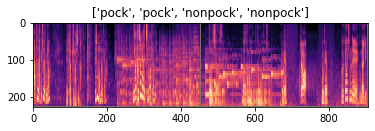

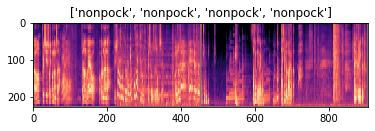

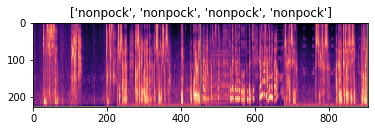

In [8]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 4

class_names = {
    "0": "nonpock", 
    "1": "pock"
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['val']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
            
            torch.save(model.state_dict(), './task1_checkpoint/president_model-epoch-{}.pt'.format(epoch))
           
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), './task1_checkpoint/president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(model.parameters(), 
#                          lr = 0.05,
#                          momentum=0.9,
#                          weight_decay=1e-4)

optimizer_ft = optim.Adam(model.parameters(), lr=0.00001)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, 30)

In [14]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.00 Acc: 99.7
val Loss: 1.82 Acc: 63.9
==> best model saved - 0 / 63.9
Epoch 1/99
----------
train Loss: 0.00 Acc: 99.8
val Loss: 1.95 Acc: 62.2
Epoch 2/99
----------
train Loss: 0.00 Acc: 99.8
val Loss: 2.02 Acc: 61.4
Epoch 3/99
----------
train Loss: 0.00 Acc: 99.7
val Loss: 2.04 Acc: 61.4
Epoch 4/99
----------
train Loss: 0.00 Acc: 99.8
val Loss: 1.97 Acc: 62.7
Epoch 5/99
----------
train Loss: 0.00 Acc: 99.7
val Loss: 2.01 Acc: 61.5
Epoch 6/99
----------
train Loss: 0.00 Acc: 99.9
val Loss: 2.04 Acc: 61.1
Epoch 7/99
----------
train Loss: 0.00 Acc: 99.8
val Loss: 2.12 Acc: 60.7
Epoch 8/99
----------
train Loss: 0.00 Acc: 99.7
val Loss: 2.11 Acc: 60.8
Epoch 9/99
----------
train Loss: 0.00 Acc: 99.8
val Loss: 2.16 Acc: 60.5
Epoch 10/99
----------
train Loss: 0.00 Acc: 99.8
val Loss: 2.13 Acc: 61.1
Epoch 11/99
----------
train Loss: 0.01 Acc: 99.7
val Loss: 2.05 Acc: 61.7
Epoch 12/99
----------
train Loss: 0.00 Acc: 99.7
val Loss: 1.97 Acc: 62.5
Epo

KeyboardInterrupt: 